In [5]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd



In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##Data Handling

In [7]:
df = pd.read_csv("/content/shampoo_sales.csv")

In [8]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


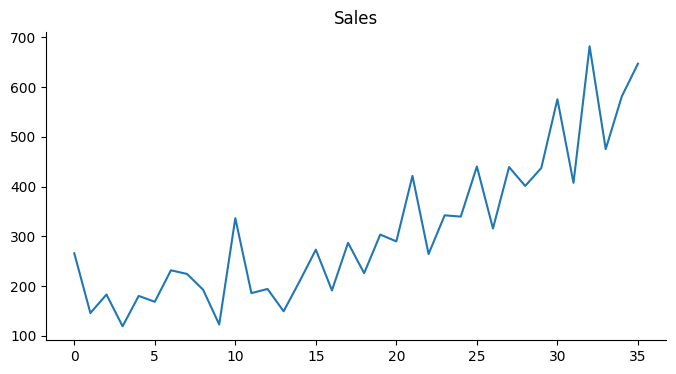

In [9]:
from matplotlib import pyplot as plt
df['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

In [10]:
#check if the data has any missing values
df.isnull().sum().sum()

0

Custom DataLoader

In [11]:
class ShampooSalesDataset(Dataset):
    def __init__(self, df, sequence_length):
        self.sequence_length = sequence_length
        self.df = df
        # Using minmaxscaler to normalize the sale values
        self.scaler = MinMaxScaler()
        self.scaler = self.scaler.fit(np.expand_dims(df["Sales"], axis=1))
        self.normalized_data = self.scaler.transform(np.expand_dims(df["Sales"], axis=1))

    def __len__(self):
        return len(self.df) - self.sequence_length + 1

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        input_sequence = self.normalized_data[idx:idx_end]
        target_value = self.normalized_data[idx_end - 1]

        #returning the input_sequence and normalized target values
        return torch.FloatTensor(input_sequence), torch.FloatTensor(target_value)

# df is the preprocessed DataFrame with 'Month' as the index and 'Sales' as the target variable
sequence_length = 5
shampoo_dataset = ShampooSalesDataset(df, sequence_length)


Data Splitting

In [12]:
# train, validation, and test sets
train_size = int(0.7 * len(shampoo_dataset))
validation_size = int(0.15 * len(shampoo_dataset))
test_size = len(shampoo_dataset) - train_size - validation_size


train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
    shampoo_dataset, [train_size, validation_size, test_size]
)


# Creating DataLoader instances
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
print("train size :" , train_size)
print("test size :" , test_size)
print("val size :" , validation_size)

train size : 22
test size : 6
val size : 4


##LSTM Model

In [14]:
class SalesPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, sequence_length , n_layers=2):
    super(SalesPredictor, self).__init__()

    # Define the parameters for the LSTM and linear layers
    self.n_hidden = n_hidden
    self.seq_len = sequence_length
    self.n_layers = n_layers

    # LSTM layer to capture sequential patterns in the input data
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.2
    )

    # Linear layer for making predictions based on LSTM output
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    # Reset the hidden state of the LSTM when starting a new sequence
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    # Forward pass through the LSTM and linear layers, pass the input sequence through the LSTM layer
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [15]:
#Define model
model = SalesPredictor(n_features=1,
  n_hidden=64,
  sequence_length=5,
  n_layers=2).to(device)

#Loss fuction
criterion = torch.nn.MSELoss(reduction='sum')

#Optimizer with lr 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [16]:
#Plot function
def plot_loss(train_hist, validation_hist):
    plt.figure(figsize=(10, 6))
    plt.plot(train_hist, label='Training Loss', marker='o')
    plt.plot(validation_hist, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def train_model(num_epochs, model, train_loader, validation_loader, criterion, optimizer):
    #List for storing the loss values
    train_hist = np.zeros(num_epochs)
    validation_hist = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.reset_hidden_state()
        epoch_loss = 0

        # Training Loop
        model.train()
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)

            y_pred = model(features)
            loss = criterion(y_pred.float(), labels)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_hist[epoch] = avg_epoch_loss

        # Validation Loop
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            for features_val, labels_val in validation_loader:
                features_val = features_val.to(device)
                labels_val = labels_val.to(device)

                y_pred_val = model(features_val)
                loss_val = criterion(y_pred_val, labels_val)
                validation_loss += loss_val.item()

            avg_validation_loss = validation_loss / len(validation_loader)
            validation_hist[epoch] = avg_validation_loss

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss}, Validation Loss: {avg_validation_loss}")

    # Plotting
    plot_loss(train_hist, validation_hist)

    return train_hist, validation_hist






Epoch [1/30], Train Loss: 2.830578565597534, Validation Loss: 1.6537028551101685
Epoch [2/30], Train Loss: 2.8154616355895996, Validation Loss: 1.644456148147583
Epoch [3/30], Train Loss: 2.787858486175537, Validation Loss: 1.6340582370758057
Epoch [4/30], Train Loss: 2.7664995193481445, Validation Loss: 1.625709056854248
Epoch [5/30], Train Loss: 2.738233804702759, Validation Loss: 1.6162617206573486
Epoch [6/30], Train Loss: 2.6929426193237305, Validation Loss: 1.607490062713623
Epoch [7/30], Train Loss: 2.6982948780059814, Validation Loss: 1.598476529121399
Epoch [8/30], Train Loss: 2.668997049331665, Validation Loss: 1.5902591943740845
Epoch [9/30], Train Loss: 2.6519763469696045, Validation Loss: 1.58058500289917
Epoch [10/30], Train Loss: 2.620515823364258, Validation Loss: 1.5719828605651855
Epoch [11/30], Train Loss: 2.6017277240753174, Validation Loss: 1.5618277788162231
Epoch [12/30], Train Loss: 2.5752460956573486, Validation Loss: 1.553283452987671
Epoch [13/30], Train Loss

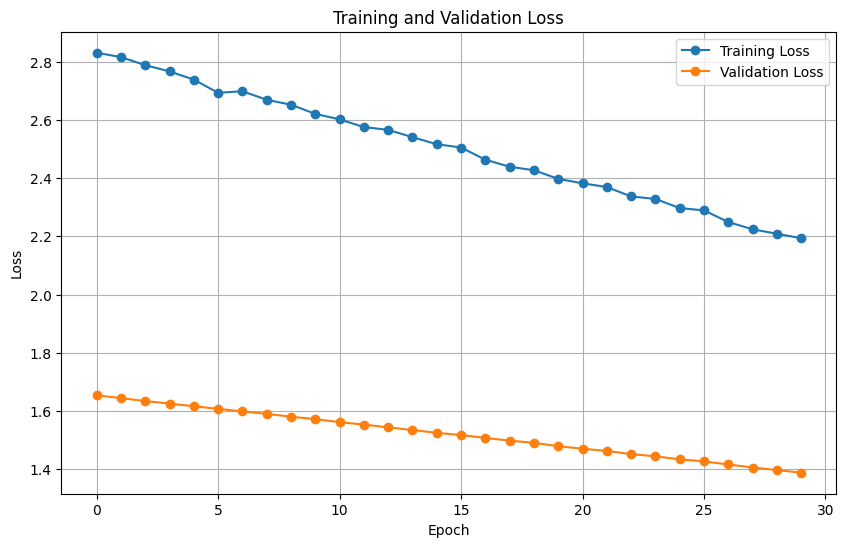

In [18]:
# Example usage
train_hist, validation_hist = train_model(num_epochs=30, model=model, train_loader=train_loader,
                                          validation_loader=validation_loader, criterion=criterion, optimizer=optimizer)

In [19]:
import matplotlib.pyplot as plt

def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predicted_values = []
    true_labels = []

    with torch.no_grad():
        for features_test, labels_test in test_loader:
            features_test = features_test.to(device)
            labels_test = labels_test.to(device)

            y_pred_test = model(features_test)
            loss_test = criterion(y_pred_test, labels_test)
            test_loss += loss_test.item()

            predicted_values.extend(y_pred_test.cpu().numpy())
            true_labels.extend(labels_test.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss}")

    return np.array(predicted_values), np.array(true_labels)

# Assuming you have the `test_loader` DataLoader
predicted_values, true_labels = test_model(model, test_loader, criterion)


Test Loss: 0.7268603444099426


Forecasting the future values for next 30 months

In [20]:


# trained model = 'model' and DataLoader = 'test_loader'
model.eval()

# Get the last sequence from the test loader
for features_test, labels_test in test_loader:
    last_sequence = features_test[-1, :, :].unsqueeze(0).to(device)
    break  #We need only 1 model for testing

# Forecast sales for the next 30 months
future_steps = 30
forecast = []
with torch.no_grad():
    for _ in range(future_steps):
        output = model(last_sequence)
        forecast.append(output.squeeze().item())
        # Update the last sequence with the predicted value (shift by 1)
        last_sequence = torch.cat((last_sequence[:, 1:], output.unsqueeze(0)), dim=1)

# Fit the scaler with the training data
scaler = MinMaxScaler()
scaler.fit(np.expand_dims(df["Sales"], axis=1))

# Inverse scaling to get actual sales values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create future dates for plotting
last_date = df.index[-1]  # Assuming df is the original DataFrame


# Print or use 'forecast' and 'future_dates' for plotting
print("Forecasted Sales:", forecast)



Forecasted Sales: [[184.16765066]
 [184.03471252]
 [183.90194628]
 [183.80227936]
 [183.73485652]
 [183.69144798]
 [183.66413003]
 [183.64710033]
 [183.63651022]
 [183.62992389]
 [183.62585303]
 [183.62335853]
 [183.62185344]
 [183.62096884]
 [183.62046155]
 [183.62019324]
 [183.62005069]
 [183.61999619]
 [183.61997942]
 [183.61997942]
 [183.619992  ]
 [183.62000458]
 [183.62001296]
 [183.62003392]
 [183.62003392]
 [183.62004231]
 [183.6200465 ]
 [183.62005069]
 [183.62005489]
 [183.62005069]]


In [21]:
fore = np.array(forecast).reshape(-1, 1)
fore

array([[184.16765066],
       [184.03471252],
       [183.90194628],
       [183.80227936],
       [183.73485652],
       [183.69144798],
       [183.66413003],
       [183.64710033],
       [183.63651022],
       [183.62992389],
       [183.62585303],
       [183.62335853],
       [183.62185344],
       [183.62096884],
       [183.62046155],
       [183.62019324],
       [183.62005069],
       [183.61999619],
       [183.61997942],
       [183.61997942],
       [183.619992  ],
       [183.62000458],
       [183.62001296],
       [183.62003392],
       [183.62003392],
       [183.62004231],
       [183.6200465 ],
       [183.62005069],
       [183.62005489],
       [183.62005069]])

In [22]:
b = np.array(df["Sales"]).reshape(-1,1)
b

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

Plot the forecast

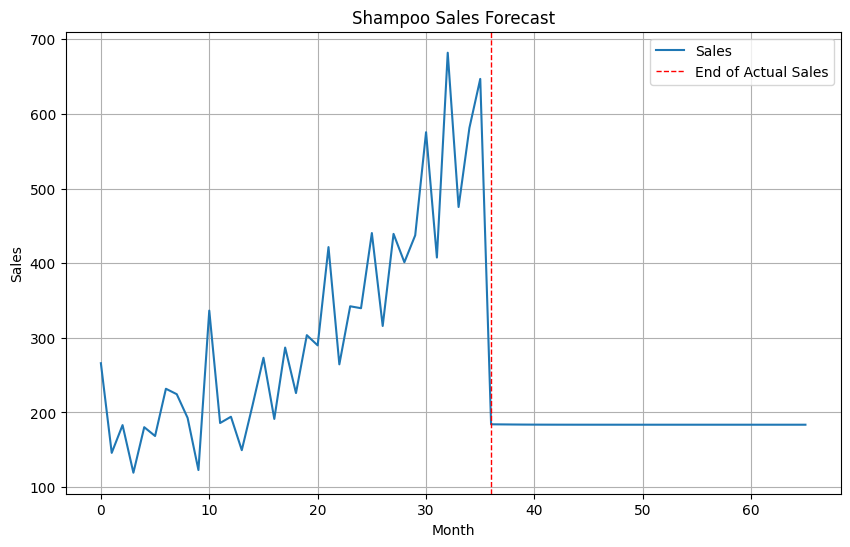

In [23]:
concatenated_sales = np.concatenate((b, fore))

# Plot actual and forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(concatenated_sales, label='Sales')
plt.axvline(x=len(df), color='red', linestyle='--', linewidth=1, label='End of Actual Sales')
plt.title('Shampoo Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In the above graph the sales after the dotted lines are the predicted sales i.e the LSTM has obtained the forecasted values based on the past data.

##Hyper parameter tuning

Batchsize
Dropout rate
Epochs
Number of hidden layers
Learning rate
Loss function
Activation functions


Here i will tune the model using diff learning rates, dropout rate
epochs and Number of hidden layers.



In [24]:
#Define model1
model1 = SalesPredictor(n_features=1,
  n_hidden=256,
  sequence_length=5,
  n_layers=2).to(device)

#Loss fuction
criterion = torch.nn.MSELoss(reduction='sum')

#Optimizer with lr 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch [1/100], Train Loss: 3.183443069458008, Validation Loss: 1.7939382791519165
Epoch [2/100], Train Loss: 3.1868104934692383, Validation Loss: 1.7934104204177856
Epoch [3/100], Train Loss: 3.1894328594207764, Validation Loss: 1.7948280572891235
Epoch [4/100], Train Loss: 3.182101249694824, Validation Loss: 1.7943187952041626
Epoch [5/100], Train Loss: 3.1948623657226562, Validation Loss: 1.7942516803741455
Epoch [6/100], Train Loss: 3.191213846206665, Validation Loss: 1.7942757606506348
Epoch [7/100], Train Loss: 3.1833579540252686, Validation Loss: 1.7941648960113525
Epoch [8/100], Train Loss: 3.1834678649902344, Validation Loss: 1.794126033782959
Epoch [9/100], Train Loss: 3.187835693359375, Validation Loss: 1.7950239181518555
Epoch [10/100], Train Loss: 3.1829071044921875, Validation Loss: 1.7947500944137573
Epoch [11/100], Train Loss: 3.1801581382751465, Validation Loss: 1.7944762706756592
Epoch [12/100], Train Loss: 3.191526174545288, Validation Loss: 1.794425129890442
Epoch [1

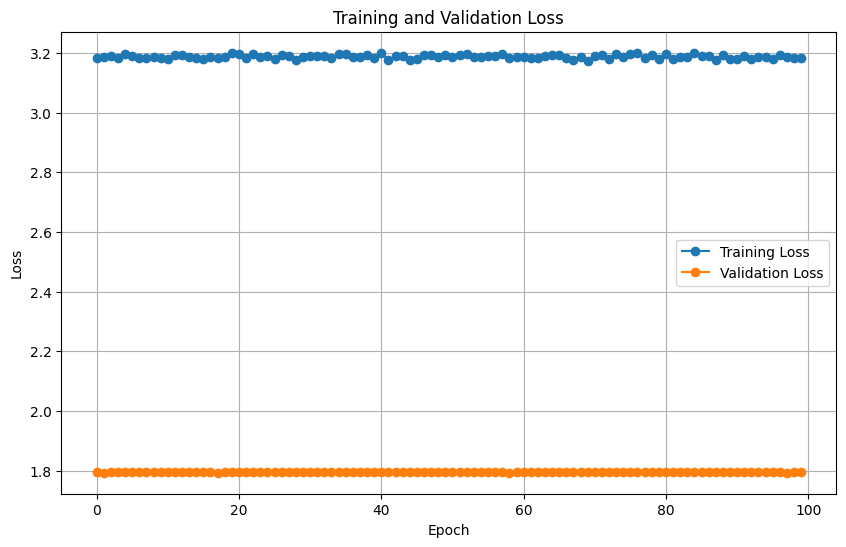

In [25]:
train_hist, validation_hist = train_model(num_epochs= 100, model=model1, train_loader=train_loader,
                                          validation_loader=validation_loader, criterion=criterion, optimizer=optimizer)

In [26]:
predicted_values1, true_labels1 = test_model(model1, test_loader, criterion)

Test Loss: 1.041196584701538


In [27]:
#Define model2
model2 = SalesPredictor(n_features=1,
  n_hidden=64,
  sequence_length=5,
  n_layers=2).to(device)

#Loss fuction
criterion = torch.nn.MSELoss(reduction='sum')

#Optimizer with lr 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Epoch [1/50], Train Loss: 3.8456718921661377, Validation Loss: 2.033539056777954
Epoch [2/50], Train Loss: 3.8547651767730713, Validation Loss: 2.0355663299560547
Epoch [3/50], Train Loss: 3.8515543937683105, Validation Loss: 2.0338962078094482
Epoch [4/50], Train Loss: 3.8580358028411865, Validation Loss: 2.038076639175415
Epoch [5/50], Train Loss: 3.8624229431152344, Validation Loss: 2.0370707511901855
Epoch [6/50], Train Loss: 3.9004099369049072, Validation Loss: 2.0379366874694824
Epoch [7/50], Train Loss: 3.864652156829834, Validation Loss: 2.033484697341919
Epoch [8/50], Train Loss: 3.905548334121704, Validation Loss: 2.037990093231201
Epoch [9/50], Train Loss: 3.863375186920166, Validation Loss: 2.0359585285186768
Epoch [10/50], Train Loss: 3.846198797225952, Validation Loss: 2.037416934967041
Epoch [11/50], Train Loss: 3.8557076454162598, Validation Loss: 2.0356881618499756
Epoch [12/50], Train Loss: 3.8538856506347656, Validation Loss: 2.036604881286621
Epoch [13/50], Train Lo

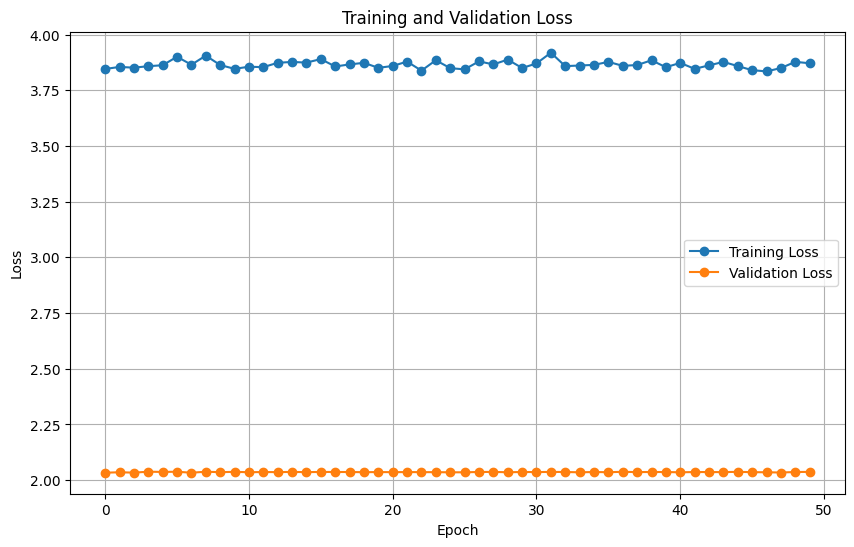

In [28]:
train_hist, validation_hist = train_model(num_epochs= 50, model=model2, train_loader=train_loader,
                                          validation_loader=validation_loader, criterion=criterion, optimizer=optimizer)

In [29]:
predicted_values2, true_labels2 = test_model(model2, test_loader, criterion)

Test Loss: 1.245723843574524


In [35]:
import pandas as pd

# Define data
data = {'model' : ['model'],
    'lr': [1e-4],
    'batch_size': [64],
    'n_hidden': [64],
    'epochs': [30],
    'train_loss': [0.47358688712120056]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


   model      lr  batch_size  n_hidden  epochs  train_loss
0  model  0.0001          64        64      30    0.473587


In [36]:
model_1 = {'model' : ['model1'],
    'lr': [1e-3],
    'batch_size': [64],
    'n_hidden': [256],
    'epochs': [100],
    'train_loss': [1.041196584701538]
}

model_2 = {'model' : ['model2'],
    'lr': [1e-5],
    'batch_size': [64],
    'n_hidden': [64],
    'epochs': [50],
    'train_loss': [1.245723843574524]
}

df = df.append(pd.DataFrame(model_1), ignore_index=True)
df = df.append(pd.DataFrame(model_2), ignore_index=True)


<ipython-input-36-bf3cfc64479f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(model_1), ignore_index=True)
<ipython-input-36-bf3cfc64479f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(model_2), ignore_index=True)


In [37]:
df

,model,lr,batch_size,n_hidden,epochs,train_loss
0,model,0.00010,64,64,30,0.473587
1,model1,0.00100,64,256,100,1.041197
2,model2,0.00001,64,64,50,1.245724


This the set of hyperparameters that i have tried. the loss is minimum for the first model, we can conclude that we need to keep the model simple to get good results.